In [1]:
import pandas as pd
import numpy as np
import requests
import geopandas as gpd
import zipfile
import matplotlib.pyplot as plt
import re
import os
import math
import warnings
from bs4 import BeautifulSoup
from sqlalchemy import create_engine
from keplergl import KeplerGl
warnings.filterwarnings('ignore')

In [12]:
pip install fastparquet

     |████████████████████████████████| 790 kB 1.4 MB/s eta 0:00:01
     |████████████████████████████████| 12.1 MB 13.9 MB/s eta 0:00:01
     |████████████████████████████████| 3.2 MB 53.9 MB/s eta 0:00:01
  Attempting uninstall: pandas
    Found existing installation: pandas 1.4.2
    Uninstalling pandas-1.4.2:
      Successfully uninstalled pandas-1.4.2
Note: you may need to restart the kernel to use updated packages.


In [21]:
# Constants
DATA_PATH = './data'
YELLOW_TAXI_URL = 'https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page'
ID_LOOKUP_URL = 'https://d37ci6vzurychx.cloudfront.net/misc/taxi_zones.zip'

### Part 1: Data Preprocessing
#### Yellow Taxi Data

In [22]:
def get_id_lookup():
    """Download the Taxi Zones file and get a lookup for location ID.

    Returns:
        A dataframe contains location IDs and their coordinates.
    """
    zip_path = DATA_PATH + '/taxi_zones.zip'
    file_path = DATA_PATH + '/taxi_zones/'
    url_data = requests.get(ID_LOOKUP_URL).content
    with open(zip_path, 'wb') as f:
        f.write(url_data)
    zip_data = zipfile.ZipFile(zip_path, 'r')
    for f in zip_data.namelist():
        zip_data.extract(f, file_path)
    zip_data.close()
    id_lookup = gpd.read_file(file_path + '/taxi_zones.shp')
    id_lookup = id_lookup.to_crs(4326)  # EPSG:4326
    id_lookup['Lon'] = id_lookup['geometry'].map(lambda x: x.centroid.x)
    id_lookup['Lat'] = id_lookup['geometry'].map(lambda x: x.centroid.y)
    id_lookup = id_lookup[['LocationID', 'Lon', 'Lat']]
    return id_lookup

def get_taxi_urls():
    """Get urls of yellow taxi parquet data from 2009-01 to 2015-06.

    Returns:
        A list of urls.
    """
    rsp = requests.get(YELLOW_TAXI_URL)
    page_content = BeautifulSoup(rsp.content, 'lxml')
    urls = []
    for year_tab in page_content.find_all('div', {'id': re.compile('faq\d{4}')}):
        for month_tab in year_tab.find_all('a', {'title': 'Yellow Taxi Trip Records'}):
            url = month_tab.get('href')
            if url[-15:-8] >= '2009-01' and url[-15:-8] <= '2015-06':
                urls.append(url)
    return urls

def haversine(theta):
    """The Haversine function for caculating distance.

    Args:
        theta: A degree in radians.

    Returns:
        Value of the Haversine function at theta.
    """
    return math.sin(theta / 2.) ** 2

def get_distance(lon1, lat1, lon2, lat2):
    """Get the distance between two longitude and latitude coordinates.

    Args:
        lon1: Longitude of the first coordinate.
        lat1: Latitude of the first coordinate.
        lon2: Longitude of the second coordinate.
        lat2: Latitude of the second coordinate.

    Returns:
        Distance between two longitude and latitude coordinates.
    """
    lon1 = math.radians(lon1)
    lat1 = math.radians(lat1)
    lon2 = math.radians(lon2)
    lat2 = math.radians(lat2)
    hs = haversine(lat2 - lat1) + math.cos(lat1) * math.cos(lat2) * haversine(lon2 - lon1)
    return 2 * 6371 * math.asin(hs ** 0.5)

def preprocess_taxi_data(url, id_lookup):
    """Preprocess yellow taxi data in a month.

    Args:
        url: Url for the data.
        id_lookup: An dataframe contains location IDs and their coordinate.

    Returns:
        A yellow taxi trip dataframe after filtering and cleaning.
    """
    df = pd.read_parquet(url, engine='fastparquet')
    if 'PULocationID' in df.columns:
        df = pd.merge(df, id_lookup, left_on='PULocationID', right_on='LocationID')
        df = pd.merge(df, id_lookup, left_on='DOLocationID', right_on='LocationID', suffixes=('', '_DO'))
        df = df[['tpep_pickup_datetime', 'tip_amount', 'Lon', 'Lat', 'Lon_DO', 'Lat_DO']]
    elif 'pickup_longitude' in df.columns:
        df = df[['pickup_datetime', 'tip_amount', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']]
    else:
        df = df[['Trip_Pickup_DateTime', 'Tip_Amt', 'Start_Lon', 'Start_Lat', 'End_Lon', 'End_Lat']]
    # keep necessary columns
    df.columns = ['pickup_datetime', 'tip_amount', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']
    df.dropna(inplace=True)
    # filter geographical area
    df = df[(df.pickup_latitude.between(40.560445, 40.908524) & (df.dropoff_latitude.between(40.560445, 40.908524)))
        & (df.pickup_longitude.between(-74.242330,-73.717047)) & (df.dropoff_longitude.between(-74.242330,-73.717047))]
    # sample len(uber) / months rows
    df = df.sample(n=200000 // 78, replace=False)
    # compute distance between two coordinates
    df['straight_distance'] = list(map(get_distance, df['pickup_longitude'], df['pickup_latitude'], df['dropoff_longitude'], df['dropoff_latitude']))
    df.reset_index(drop=True, inplace=True)
    return df

def get_and_preprocess_taxi_data():
    """Download and preprocess all the yellow taxi data.

    Returns:
        Full yellow taxi trip dataframe after filtering and cleaning.
    """
    id_lookup = get_id_lookup()
    urls = get_taxi_urls()
    df_list = []
    # save tmp files in case of crashing
    if not os.path.exists(DATA_PATH + '/tmp'):
        os.makedirs(DATA_PATH + '/tmp')
    for url in urls:
        month = url[-15:-8]
        if month == '2009-12':
            df = preprocess_taxi_data(url, id_lookup)
            df.to_csv(DATA_PATH + '/tmp/' + month + '.csv', index=False)
            df_list.append(df)
            print(month + ' done.')
    full_df = pd.concat(df_list)
    full_df['pickup_datetime'] = pd.to_datetime(full_df['pickup_datetime'])
    full_df.sort_values(by='pickup_datetime', inplace=True)
    full_df.reset_index(drop=True, inplace=True)
    full_df.to_csv(DATA_PATH + '/taxi_df.csv', index=False)
    return full_df

### Uber Data

In [23]:
def get_and_preprocess_uber_data():
    """Download and preprocess the uber data.

    Returns:
        Uber dataframe after filtering and cleaning.
    """
    df = pd.read_csv('./data/uber_rides_sample.csv')
    # filter abnormal rows
    df = df[(df['passenger_count'] > 0) & (df['passenger_count'] < 10)]
    df = df[['pickup_datetime', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']]
    df['straight_distance'] = list(map(get_distance, df['pickup_longitude'], df['pickup_latitude'], df['dropoff_longitude'], df['dropoff_latitude']))
    df.dropna(inplace=True)
    # filter geographical area
    df = df[(df.pickup_latitude.between(40.560445, 40.908524) & (df.dropoff_latitude.between(40.560445, 40.908524)))
        & (df.pickup_longitude.between(-74.242330,-73.717047)) & (df.dropoff_longitude.between(-74.242330,-73.717047))]
    df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
    df.sort_values(by='pickup_datetime', inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df

### Weather Data

In [24]:
def get_hourly_weather_data(df):
    """Preprocess weather data in hour intervals.

    Args:
        df: Raw weather dataframe.

    Returns:
        Hourly weather data after filtering and cleaning.
    """
    df = df[['DATE', 'HourlyPrecipitation', 'HourlyWindSpeed']].copy()
    df['DATE'] = pd.to_datetime(df['DATE']).dt.floor('h')
    df['HourlyPrecipitation'] = pd.to_numeric(df['HourlyPrecipitation'], errors='coerce')
    df['HourlyWindSpeed'] = pd.to_numeric(df['HourlyWindSpeed'], errors='coerce')
    df.drop_duplicates('DATE', inplace=True)
    df.reset_index(drop=True, inplace=True)
    df.columns = ['date', 'hourly_precipitation', 'hourly_wind_speed']
    return df

def get_daily_weather_data(df):
    """Preprocess weather data in day intervals.

    Args:
        df: Raw weather dataframe.

    Returns:
        Daily weather data after filtering and cleaning.
    """
    df = df[['DATE', 'DailyAverageWindSpeed']].copy()
    df['DATE'] = pd.to_datetime(df['DATE']).dt.floor('d')
    df['DailyAverageWindSpeed'] = pd.to_numeric(df['DailyAverageWindSpeed'], errors='coerce')
    df.dropna(inplace=True)
    df.drop_duplicates('DATE', inplace=True)
    df.reset_index(drop=True, inplace=True)
    df.columns = ['date', 'daily_average_wind_speed']
    return df

def get_and_preprocess_weather_data():
    """Download and preprocess the weather data.

    Returns:
        Hourly weather dataframe and daily weather dataframe.
    """
    hourly = []
    daily = []
    for f in os.listdir('./data/weather'):
        df = pd.read_csv('./data/weather/' + f)
        hourly.append(get_hourly_weather_data(df))
        daily.append(get_daily_weather_data(df))
    hourly_weather_df = pd.concat(hourly)
    hourly_weather_df.sort_values(by='date', inplace=True)
    hourly_weather_df.reset_index(drop=True, inplace=True)
    daily_weather_df = pd.concat(daily)
    daily_weather_df.sort_values(by='date', inplace=True)
    daily_weather_df.reset_index(drop=True, inplace=True)
    return hourly_weather_df, daily_weather_df

In [27]:
taxi_df = get_and_preprocess_taxi_data()
uber_df = get_and_preprocess_uber_data()
hourly_weather_df, daily_weather_df = get_and_preprocess_weather_data()

2009-12 done.


## Part 2: Storing Data

In [28]:
engine = create_engine('sqlite:///project.db')
taxi_df.to_sql('yellow_taxi', con=engine, if_exists='replace', index=False)
uber_df.to_sql('uber', con=engine, if_exists='replace', index=False)
hourly_weather_df.to_sql('hourly_weather', con=engine, if_exists='replace', index=False)
daily_weather_df.to_sql('daily_weather', con=engine, if_exists='replace', index=False)

1246

## Part 3: Understanding Data

Q: For 01-2009 through 06-2015, what hour of the day was the most popular to take a Yellow Taxi? The result should have 24 bins.

A: 19th hour of the day was the most popular.

In [29]:
query = """
    SELECT STRFTIME('%H', pickup_datetime) hour, count(*) trip_cnt
    FROM yellow_taxi
    GROUP BY hour
    ORDER BY trip_cnt DESC
"""
pd.read_sql(query, engine)

,hour,trip_cnt
0,19,180
1,20,177
2,18,154
3,22,144
4,15,141
5,13,140
6,23,131
7,21,131
8,17,129
9,09,129


Q: For the same time frame, what day of the week was the most popular to take an Uber? The result should have 7 bins.

A: Friday is the most popular day to take an Uber.

In [30]:
query = """
    SELECT STRFTIME('%w', pickup_datetime) day_of_week, count(*) trip_cnt
    FROM uber
    GROUP BY day_of_week
    ORDER BY trip_cnt DESC
"""
pd.read_sql(query, engine)

,day_of_week,trip_cnt
0,5,30070
1,6,29493
2,4,29248
3,3,28231
4,2,27417
5,0,25765
6,1,24562


Q: What is the 95% percentile of distance traveled for all hired trips during July 2013?

A: The 95% percentile is 10.543089.

In [31]:
query = """
    WITH tmp AS (
        SELECT straight_distance
        FROM yellow_taxi
        WHERE STRFTIME('%Y-%m', pickup_datetime) = '2013-07'
        UNION ALL
        SELECT straight_distance
        FROM uber
        WHERE STRFTIME('%Y-%m', pickup_datetime) = '2013-07'
    )
    SELECT straight_distance '95% percentile'
    FROM tmp
    ORDER BY straight_distance
    LIMIT 1
    OFFSET(
        SELECT CAST(COUNT(*)*0.95 AS INT)
        FROM tmp
    )
"""
pd.read_sql(query, engine)

,95% percentile
0,10.268339


Q: What were the top 10 days with the highest number of hired rides for 2009, and what was the average distance for each day?

In [32]:
query = """
    WITH tmp AS (
        SELECT STRFTIME('%Y-%m-%d', pickup_datetime) date, straight_distance
        FROM yellow_taxi
        WHERE STRFTIME('%Y', pickup_datetime) = '2009'
        UNION ALL
        SELECT STRFTIME('%Y-%m-%d', pickup_datetime) date, straight_distance
        FROM uber
        WHERE STRFTIME('%Y', pickup_datetime) = '2009'
    )
    SELECT date, COUNT(*) trip_cnt, AVG(straight_distance) average_distance
    FROM tmp
    GROUP BY date
    ORDER BY trip_cnt DESC
    LIMIT 10
"""
pd.read_sql(query, engine)

,date,trip_cnt,average_distance
0,2009-12-11,218,3.034457
1,2009-12-05,216,3.078534
2,2009-12-18,211,2.735593
3,2009-12-04,207,2.936819
4,2009-12-03,198,3.087233
5,2009-12-22,185,2.886087
6,2009-12-19,185,2.714283
7,2009-12-10,185,3.148842
8,2009-12-01,185,2.614269
9,2009-12-16,183,3.385772


Q: Which 10 days in 2014 were the windiest on average, and how many hired trips were made on those days?

In [33]:
query = """ 
    WITH full_trips AS (
        SELECT STRFTIME('%m-%d', pickup_datetime) date
        FROM yellow_taxi
        WHERE STRFTIME('%Y', pickup_datetime) = '2014'
        UNION ALL
        SELECT STRFTIME('%m-%d', pickup_datetime) date
        FROM uber
        WHERE STRFTIME('%Y', pickup_datetime) = '2014'
    )
    SELECT a.date, b.daily_average_wind_speed, COUNT(*) trip_cnt
    FROM full_trips a
    JOIN daily_weather b
    ON a.date = STRFTIME('%m-%d', b.date)
    WHERE STRFTIME('%Y', b.date) = '2014'
    GROUP BY a.date
    ORDER BY b.daily_average_wind_speed DESC
    LIMIT 10
"""
pd.read_sql(query, engine)

,date,daily_average_wind_speed,trip_cnt
0,03-13,14.1,106
1,01-07,13.1,77
2,02-13,12.6,63
3,01-02,12.2,63
4,03-26,11.9,96
5,12-07,11.8,73
6,12-08,11.5,77
7,11-02,10.8,80
8,03-29,10.8,107
9,02-14,10.4,71


Q: During Hurricane Sandy in NYC (Oct 29-30, 2012), plus the week leading up and the week after, how many trips were taken each hour, and for each hour, how much precipitation did NYC receive and what was the sustained wind speed? There should be an entry for every single hour, even if no rides were taken, no precipitation was measured, or there was no wind.

In [34]:
query = """ 
    WITH RECURSIVE hours AS (
        SELECT DATETIME('2012-10-22') as date
        UNION ALL
        SELECT DATETIME(date, '+1 hour')
        FROM hours
        WHERE date < DATETIME('2012-11-06 23:00:00')
    ),
    full_trips AS (
        SELECT STRFTIME('%Y-%m-%d %H', pickup_datetime) date
        FROM yellow_taxi
        WHERE pickup_datetime between datetime('2012-10-22') and datetime('2012-11-07')
        UNION ALL
        SELECT STRFTIME('%Y-%m-%d %H', pickup_datetime) date
        FROM uber
        WHERE pickup_datetime between datetime('2012-10-22') and datetime('2012-11-07')
    ),
    trip_stats AS (
        SELECT STRFTIME('%Y-%m-%d %H', hours.date) hour, COUNT(*) trip_cnt
        FROM hours
        LEFT JOIN full_trips a
        ON STRFTIME('%Y-%m-%d %H', hours.date) = a.date
        GROUP BY hour
    )
    SELECT a.hour, trip_cnt, hourly_precipitation, hourly_wind_speed
    FROM trip_stats a
    LEFT JOIN hourly_weather b
    ON a.hour = STRFTIME('%Y-%m-%d %H', b.date)
"""
pd.read_sql(query, engine)

,hour,trip_cnt,hourly_precipitation,hourly_wind_speed
0,2012-10-22 00,2,0.0,7.0
1,2012-10-22 01,1,0.0,5.0
2,2012-10-22 02,1,0.0,7.0
3,2012-10-22 03,1,0.0,0.0
4,2012-10-22 04,1,0.0,0.0
...,...,...,...,...
379,2012-11-06 19,9,0.0,3.0
380,2012-11-06 20,3,0.0,7.0
381,2012-11-06 21,2,0.0,7.0
382,2012-11-06 22,4,0.0,7.0


## Part 4: Visualizing Data

Create an appropriate visualization for the first query/question in part 3.

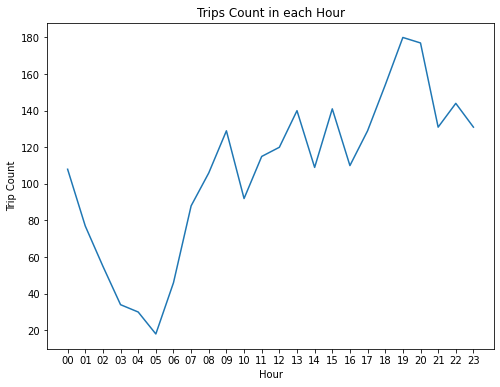

In [35]:
query = """
    SELECT STRFTIME('%H', pickup_datetime) hour, count(*) trip_cnt
    FROM yellow_taxi
    GROUP BY hour
    ORDER BY trip_cnt DESC
"""
df = pd.read_sql(query, engine)

def plot_hour_trip_cnt(df):
    """Plot number of trips in each hour.

    Args:
        df: Dataframe of hour and trip count.
    """
    df = df.sort_values(by='hour')
    plt.figure(figsize=(8, 6))
    plt.plot(df['hour'], df['trip_cnt'])
    plt.title('Trips Count in each Hour')
    plt.xlabel('Hour')
    plt.ylabel('Trip Count')
    plt.plot()

plot_hour_trip_cnt(df)

Create a visualization that shows the average distance traveled per month (regardless of year - so group by each month) for both taxis and Ubers combined. Include the 90% confidence interval around the mean in the visualization.

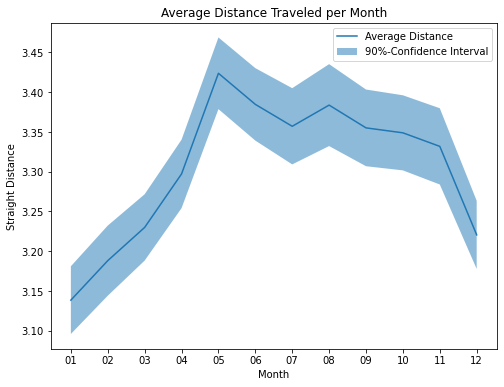

In [36]:
query = """ 
    SELECT STRFTIME('%m', pickup_datetime) month, straight_distance
    FROM yellow_taxi
    UNION ALL
    SELECT STRFTIME('%m', pickup_datetime) month, straight_distance
    FROM uber
"""
df = pd.read_sql(query, engine)

def plot_distance_interval(df):
    """Plot average distance traveled per month and their 90%-confidence interval.

    Args:
        df: Dataframe of date and distance.
    """
    df = df.groupby('month').agg(['mean', 'std', 'count'])['straight_distance'].reset_index()
    mean = df['mean']
    se = df['std'] / np.sqrt(df['count'])
    plt.figure(figsize=(8, 6))
    avg = plt.plot(df['month'], mean, label='Average Distance')
    interval = plt.fill_between(df['month'], mean-1.645*se, mean+1.645*se, alpha=0.5, label='90%-Confidence Interval')
    plt.title('Average Distance Traveled per Month')
    plt.xlabel('Month')
    plt.ylabel('Straight Distance')
    plt.legend()
    plt.plot()
plot_distance_interval(df)

Q: Define three lat/long coordinate boxes around the three major New York airports: LGA, JFK, and EWR (you can use bboxfinder to help). Create a visualization that compares what day of the week was most popular for drop offs for each airport.

A: Saturday was most popular for LGA. Friday was most popular for JFK and EWR.

In [37]:
query = """
    WITH full_trips AS (
        SELECT STRFTIME('%w', pickup_datetime) day_of_week, dropoff_longitude, dropoff_latitude
        FROM yellow_taxi
        UNION ALL
        SELECT STRFTIME('%w', pickup_datetime) day_of_weed, dropoff_longitude, dropoff_latitude
        FROM uber
    )
    SELECT 'LGA' region, day_of_week, COUNT(*) trip_cnt
    FROM full_trips
    WHERE dropoff_longitude between -73.894730 AND -73.850956
    AND dropoff_latitude between 40.762471 AND 40.785091
    GROUP BY day_of_week
    UNION ALL
    SELECT 'JFK' region, day_of_week, COUNT(*) trip_cnt
    FROM full_trips
    WHERE dropoff_longitude between -73.832932 AND -73.738174
    AND dropoff_latitude between 40.619425 AND 40.671004
    GROUP BY day_of_week
    UNION ALL
    SELECT 'EWR' region, day_of_week, COUNT(*) trip_cnt
    FROM full_trips
    WHERE dropoff_longitude between -74.205780 AND -74.145012
    AND dropoff_latitude between 40.666577 AND 40.714997
    GROUP BY day_of_week
"""

df = pd.read_sql(query, engine)

In [38]:
def plot_airport_week(df):
    """Plot number of trips in each day of a week in LGA, JFK and EWR.

    Args:
        df: Dataframe of trips in LGA, JFK and EWR.
    """
    LGA = df[df['region'] == 'LGA']
    JFK = df[df['region'] == 'JFK']
    EWR = df[df['region'] == 'EWR']
    plt.figure(figsize=(8,6))
    plt.plot(LGA['day_of_week'].astype('int')+1, LGA['trip_cnt'], label='LGA')
    plt.plot(JFK['day_of_week'].astype('int')+1, JFK['trip_cnt'], label='JFK')
    plt.plot(EWR['day_of_week'].astype('int')+1, EWR['trip_cnt'], label='EWR')
    plt.xlabel('Day of Week')
    plt.ylabel('Trip Count')
    plt.title('Trip Count in each Day of the Week')
    plt.legend()
    plt.plot()

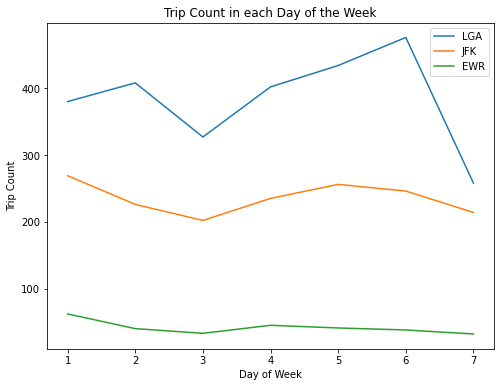

In [39]:
plot_airport_week(df)

Create a heatmap of all hired trips over a map of the area. Consider using KeplerGL or another library that helps generate geospatial visualizations.

In [40]:
query = """ 
    SELECT pickup_longitude, pickup_latitude
    FROM yellow_taxi
    UNION ALL
    SELECT pickup_longitude, pickup_latitude
    FROM uber
"""

df = pd.read_sql(query, engine)
def get_heatmap(df):
    """Heatmap of all hired trips over a map of NYC.

    Args:
        df: Dataframe of all hired trips' coordinates.
    
    Return:
        A Heatmap of all hired trips over a map of NYC.
    """
    heatmap = KeplerGl(height=600)
    heatmap.add_data(data=df)
    return heatmap
heatmap = get_heatmap(df)
heatmap

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'unnamed': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,…

Create a scatter plot that compares tip amount versus distance for Yellow Taxi rides. You may remove any outliers how you see fit.

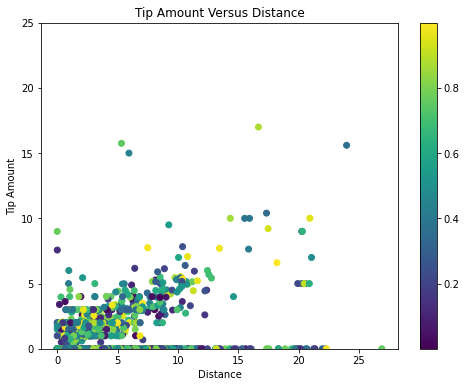

In [42]:
query = """ 
    SELECT tip_amount, straight_distance
    FROM yellow_taxi
"""

df = pd.read_sql(query, engine)

def plot_tip_distance_scatter(df):
    """Plot a scatter compares tip amount versus distance.

    Args:
        df: Dataframe of tip amounts and distance.
    """
    plt.figure(figsize=(8,6))
    plt.xlabel('Distance')
    plt.ylabel('Tip Amount')
    plt.scatter(df['straight_distance'], df['tip_amount'], c=np.random.rand(len(df)))
    plt.colorbar()
    plt.title('Tip Amount Versus Distance')
    plt.ylim((0, 25))
    plt.show()
plot_tip_distance_scatter(df)

Create another scatter plot that compares tip amount versus precipitation amount for Yellow Taxi rides. You may remove any outliers how you see fit

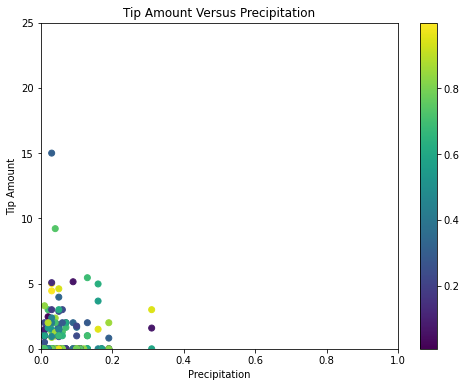

In [43]:
query = """ 
    SELECT tip_amount, hourly_precipitation
    FROM yellow_taxi a
    JOIN hourly_weather b
    ON STRFTIME('%Y-%m-%d %H', pickup_datetime) = STRFTIME('%Y-%m-%d %H', b.date)
"""

df = pd.read_sql(query, engine)

def plot_tip_precipitation_scatter(df):
    """Plot a scatter compares tip amount versus precipitation.

    Args:
        df: Dataframe of tip amounts and precipitation.
    """
    plt.figure(figsize=(8,6))
    plt.xlabel('Precipitation')
    plt.ylabel('Tip Amount')
    plt.scatter(df['hourly_precipitation'], df['tip_amount'], c=np.random.rand(len(df)))
    plt.colorbar()
    plt.title('Tip Amount Versus Precipitation')
    plt.xlim((0, 1.0))
    plt.ylim((0, 25))
    plt.show()
plot_tip_precipitation_scatter(df)